In [1]:
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, processes=True, memory_limit='8GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52012,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:52030,Total threads: 4
Dashboard: http://127.0.0.1:52033/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:52015,


2025-03-16 17:09:53,233 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:52030 (pid=22580) exceeded 95% memory budget. Restarting...
2025-03-16 17:09:53,336 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:52030' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'_create_model-a17710ceea59d7ca7d6b9a019f719147', '_create_model-f172969d1ff34f66470595680d10a4b0', '_create_model-3bb8a01fa8d3baf9eb72bbd12c0bd415', '_create_model-e5d9a1236904b6d3f97e5ec274214cf1', 'finalize-2063c327047003c984cace258b5e8c67', 'finalize-51028b3ae4d2afc2e158cd76c1519987', '_create_model-332e827563996120a130a399902f7f81', '_create_model-43a9ff0df2817267d59bbacb928516a5', '_create_model-5216270594ae08c9ffb52b4b37817104', '_create_model-1a93e64859b60ae678709b511c260808', '_create_model-50edadf4c354f153d5981ca873df9952'} (stimulus_id='handle-worker-cleanup-1742141393.3353298')
2025-03-16 17:09:53,362 - distributed.scheduler - ERROR - Couldn't 

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [3]:
import pandas as pd
import math

In [4]:
df = pd.read_csv('result_dataset.csv')

In [5]:
c = df.corr()
c[['player_metric']]

,player_metric
base_attribute_first_discipline,0.002268
duration,NaN
energy_drink_gained,0.006040
energy_drink_spent,0.005312
energy_spent,0.003331
gems_remained,0.006521
gems_spent,0.004924
gp_gained,0.008213
gp_spent,0.007310
income,0.000012


In [6]:
SHAPE = df.shape
SHAPE

(2858981, 22)

In [7]:
X = df.drop(['player_metric'], axis=1).values
Y = df[['player_metric']].values

In [82]:
def build_easy_data(n=100_000):
    return X[:n], Y[:n]

In [78]:
def build_data(x, y):
    split_value = math.floor(df.shape[0]*0.8)
    x_test, x_validate = x[:split_value], x[split_value:]
    y_test, y_validate = y[:split_value], y[split_value:]

    return (x_test,y_test), (x_validate, y_validate)

In [80]:
def build_model(lr=0.001, momentum=0.01):
    m = 1 - momentum
    model = Sequential([
        Input((X.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=lr, ema_momentum=m)
    model.compile(optimizer=opt, loss='mean_absolute_percentage_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

In [84]:
from scikeras.wrappers import KerasRegressor
from scipy.stats import loguniform

In [86]:
params = {"lr": loguniform(1e-4, 1e-2), "momentum":loguniform(1e-4, 1e-2)}

In [88]:
model = KerasRegressor(build_fn=build_model, lr=None, momentum = None)
# result = model.fit(X_test, Y_test, validation_data=(X_validate, Y_validate), epochs=50)

In [90]:
import dask.array

In [94]:
from dask_ml.model_selection import HyperbandSearchCV
search = HyperbandSearchCV(model, params, max_iter=10)
x, y = build_easy_data()
x = dask.array.from_array(x)
y = dask.array.from_array(y)
search.fit(x, y)

C:\Users\tymof\anaconda3\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 458.06 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
C:\Users\tymof\anaconda3\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 458.06 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
C:\Users\tymof\anaconda3\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 458.06 MiB.
This may cause some slowdown.
Consider loading the data wi

KilledWorker: Attempted to run task ('array-4d2a778b147268a44f0ea8c5099646b8', 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:64810. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

C:\Users\tymof\anaconda3\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 16.79 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
search.best_params_

In [44]:
model = build_model()
test, valid = build_data(X, Y)
result = model.fit(*test, validation_data=valid, epochs=50)

Epoch 1/50
71475/71475 ━━━━━━━━━━━━━━━━━━━━ 142s 2ms/step - loss: 95.5833 - mean_absolute_error: 0.0153 - val_loss: 64.8019 - val_mean_absolute_error: 0.0141
Epoch 2/50
71475/71475 ━━━━━━━━━━━━━━━━━━━━ 125s 2ms/step - loss: 65.1391 - mean_absolute_error: 0.0142 - val_loss: 64.8342 - val_mean_absolute_error: 0.0140
Epoch 3/50
71475/71475 ━━━━━━━━━━━━━━━━━━━━ 129s 2ms/step - loss: 65.0610 - mean_absolute_error: 0.0142 - val_loss: 65.3140 - val_mean_absolute_error: 0.0139
Epoch 4/50
71475/71475 ━━━━━━━━━━━━━━━━━━━━ 132s 2ms/step - loss: 65.0040 - mean_absolute_error: 0.0142 - val_loss: 64.9260 - val_mean_absolute_error: 0.0142
Epoch 5/50
71475/71475 ━━━━━━━━━━━━━━━━━━━━ 127s 2ms/step - loss: 64.9976 - mean_absolute_error: 0.0142 - val_loss: 64.8073 - val_mean_absolute_error: 0.0141
Epoch 6/50
71475/71475 ━━━━━━━━━━━━━━━━━━━━ 133s 2ms/step - loss: 64.9665 - mean_absolute_error: 0.0142 - val_loss: 64.9976 - val_mean_absolute_error: 0.0140
Epoch 7/50
71475/71475 ━━━━━━━━━━━━━━━━━━━━ 134s 2ms

In [25]:
import seaborn as sns

<Axes: >

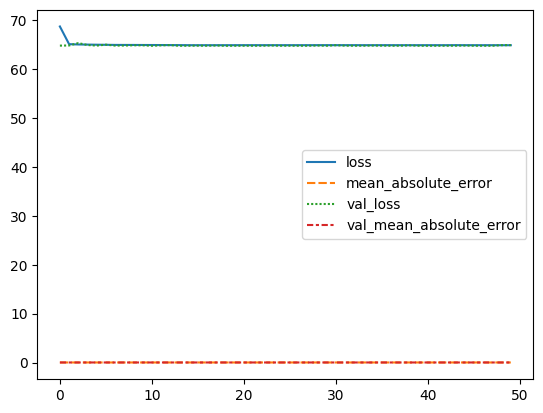

In [46]:
sns.lineplot(data=result.history)

In [48]:
data = [abs(valid[1][i][0] - x[0]) for i, x in enumerate(model.predict(valid[0]))]

17869/17869 ━━━━━━━━━━━━━━━━━━━━ 15s 824us/step


In [52]:
min(data), max(data)

(3.999182510419294e-07, 0.9980245814658701)

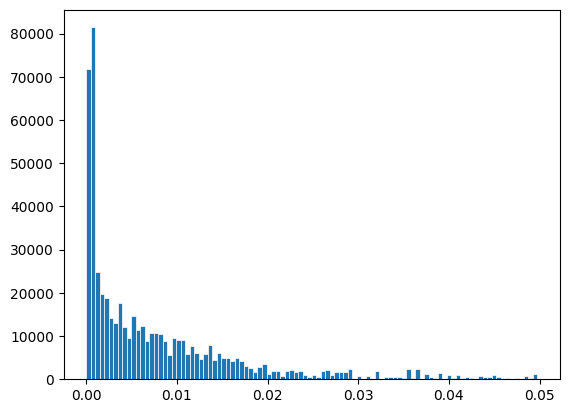

In [50]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.hist([x for x in data if x < 0.05], bins=100, linewidth=0.5, edgecolor="white")
plt.show()

In [74]:
model.save_weights('model.weights.h5')